# Parameterizing the LHCb RICH system using the pidgan `BceGAN_GP` algorithm

**Author:** [mbarbetti](https://github.com/mbarbetti)

**Date created:** 16/10/2023

**Last modified:** 07/11/2023

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-BceGAN_GP-LHCb_RICH.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/pidgan-notebooks/blob/main/tutorial-BceGAN_GP-LHCb_RICH.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open_in_GitHub-blue?style=flat&logo=github&logoColor=white&labelColor=555)](https://github.com/mbarbetti/pidgan-notebooks/blob/main/tutorial-BceGAN_GP-LHCb_RICH.ipynb)

**Description:** This tutorial demonstrates how to parameterize the high-level response of the LHCb RICH system using a Generative Adversarial Network (GAN) [[1][1]]. The code is written using the [pidgan](https://github.com/mbarbetti/pidgan) package that relies on TensorFlow and Keras as backends.

[1]: https://arxiv.org/abs/1406.2661

## Introduction

### What is LHCb?

The [**LHCb experiment**](https://lhcb-outreach.web.cern.ch) has been originally designed to study rare decays of particles containing $b$ and $c$ quarks produced at the Large Hadron Collider (LHC). The LHCb detector, shown in the background of the following photo, is a single-arm forward spectrometer covering the pseudorapidity range of $2 < \eta < 5$. The detector includes:

- **Tracking system** - used for high-precision measurements of the momentum of charged particles and the position of the primary vertices
- **Particle Identification (PID) system** - used to distiguish different species of traversing particles (i.e., muons, pions, kaons, protons)

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/lhcb.jpeg" width="800"/>
</div>

#### The RICH detectors

The LHCb PID system counts two ring-imaging Cherenkov ([RICH](https://lhcb-outreach.web.cern.ch/detector/rich-detectors/)) detectors whose response allows to separate different types of charged hadrons (e.g., pions, kaons, protons) using the [Cherenkov radiation](https://en.wikipedia.org/wiki/Cherenkov_radiation) of the traversing particles. The size of the circles produced by the Cherenkov radiation (shown on the left) within the RICH detector is related to the mass of the emitting particle. Reconstructing such circles allows to distinguish particles accordingly to their species (shown on the right).

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/rich-response.png" width="300"/>
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/rich-performance.png" width="400"/>
</div>

### What are GANs?

Generative Adversarial Networks [[1][1]] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  **Discriminator network** ($D$) - trained by a classification task to separate the generator output from the reference dataset
* **Generator network** ($G$) - trained by a simulation task to reproduce the reference dataset trying to fake the discriminator

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1][1]].

[1]: https://arxiv.org/abs/1406.2661

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/gan-scheme.png" width="800"/>
</div>

#### Mathematical details

The generator $G(z)$, fed by elements $z$ sampled according to a known distribution $p_z$ (typically gaussian), maps the **latent space** $\mathcal{Z}$ to the reference dataset $\mathcal{X}$, inducing a distribution $p_\rm{gen}$ trained to match with the target distribution $p_\rm{ref}$. The discriminator $D(x)$ outputs a single scalar, readable as the **probability** that $x$ comes from the reference dataset rather than $G$. Hence, the optimization problem corresponds to train $D$ to maximize the probability of correct labelling, and simultaneously training $G$ to hinder the discriminator task.

To define the discriminator **loss function** $\mathcal{L}^{D}_{\rm{BceGAN}}$ we can use the [binary cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) as suggested in Ref. [[2][2]]:

<center>$\mathcal{L}^{D}_{\rm{BceGAN}} (\theta_d, \theta_g) = \frac{1}{2} \left ( {\rm{BCE}}_{x \sim p_\rm{ref}} \left ( \mathbb{1}, D_{\theta_d}(x) \right ) + {\rm{BCE}}_{z \sim p_\rm{z}} \left ( \mathbb{0}, D_{\theta_d}(G_{\theta_g}(z)) \right ) \right )$</center>

where $\mathbb{1}$ and $\mathbb{0}$ are the labels for true and generated data respectively. The generator loss function $\mathcal{L}^{G}_{\rm{BceGAN}}$ follows a similar design:

<center>$\mathcal{L}^{G}_{\rm{BceGAN}} (\theta_d, \theta_g) = {\rm{BCE}}_{z \sim p_\rm{z}} \left ( \mathbb{1}, D_{\theta_d}(G_{\theta_g}(z)) \right )$</center>

Hence, the _minimax game_ of the **BceGAN algorithm** corresponds to minimize both the defined loss functions.

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator may _collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**)
* the two players may _oscillate_ during training rather than converging to the [**Nash equilibrium**](https://en.wikipedia.org/wiki/Nash_equilibrium)
* if _imbalance_ between the two players occurs, then the system is incapable of learning at all

All these drawbacks result from the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), namely the lack of information for the update of the $G$ parameters. This is due to the saturation of the $D$ that is so good in distinguishing the origin of the two samples that no errors remain to the $G$ to improve the generated space. To fix the problem, one can add _continuous noise_ to both $D$ and $G$. This trick allows to learn thanks to a non-zero gradient [[3][3]].

[2]: https://arxiv.org/abs/1511.06434
[3]: https://arxiv.org/abs/1701.04862

#### Using input conditions

Feeding the generator with additional information besides the latent space sample allows to **conditionate** its output. In particular, it's sufficient to concatenate the conditional features $x$ to the random noise $z$ passed as input to $G$ to make it able to take into account this information [[4][4]]: $y_{\rm{gen}}(x) = G(x, z)$. Obviously, to preserve the capability to learn through the minimax game, also the discriminator must be fed by the additional features $x$, simply concatenating them to either elements of the reference sample or of the generated space [[4][4]]: $D(x, y)$ with $y \in \{y_{\rm{ref}}, y_{\rm{gen}}\}$.

[4]: https://arxiv.org/abs/1606.03498

## Tutorial

The aim of this tutorial is to build a parameterization of the LHCb RICH detectors. Since we expect that the high-level response of the RICH system only depends on the kinematics of the traversing particles and the detector occupancy, the former can be parameterized training a **GAN model** properly conditioned [[4][4], [5][5]]. The pidgan package provides several GAN [`algorithms`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/algorithms) implementing some of the most used tricks presented in the literature to stablize their training [[3][3], [6][6]]. The pidgan [`players`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/players), namely the generator and discriminator networks, are designed to be trained taking conditions as input. In this notebook we will see how to build a model for the RICH system using the pidgan [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) algorithm.

[3]: https://arxiv.org/abs/1701.04862
[4]: https://arxiv.org/abs/1411.1784
[5]: https://arxiv.org/abs/1905.11825
[6]: https://arxiv.org/abs/1606.03498

### Install

The first step is to install the [pidgan](https://github.com/mbarbetti/pidgan) package and some other ones that are typically needed in machine learning applications to High Energy Physics (i.e., uproot, scipy, scikit-learn, matplotlib).

In [1]:
%%capture
!pip install pidgan[hep]

Now, let's verify the correct installation of pidgan printing its version:

In [2]:
import pidgan

pidgan.__version__

'0.0.7'

In case you're running this notebook on a machine equipped with a GPU, let's also verify the correct installation of TensorFlow:

In [3]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")  # outputs a non-empty list in case of GPU equipped

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Finally, we just have to import all the modules that we will use in the following code cells:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.preprocessing import QuantileTransformer

### Data loading

The data needed for this tutorial is provided through a CSV file downloadable from the [pidgan-notebooks](https://github.com/mbarbetti/pidgan-notebooks) repository.

**Disclaimer:** The data results from a toy model inspired to the LHCb RICH system combining its high-level response when traversed by a set of long-lived charged particles, namely muons, pions, kaons and protons.

The CSV file contains 250000 instances, 4 input features and 4 output features. Let's import the data as a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [5]:
url = "https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/data/pidgan-toy-data.csv"
data = pd.read_csv(url)

data.describe()

,P,ETA,nTracks,trackcharge,RichDLLe,RichDLLmu,RichDLLk,RichDLLp
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,19112.579988,3.362231,180.468471,0.021152,-8.959810,-1.853031,-3.614234,-3.626358
std,22610.408265,0.770202,91.626085,0.999778,16.090133,11.512878,28.799922,28.006328
min,3000.090800,1.800331,9.000999,-1.000000,-140.804340,-110.494200,-149.289830,-149.591670
25%,5970.525000,2.749856,116.000000,-1.000000,-12.259203,-3.784543,-16.768035,-18.402633
50%,10983.800000,3.340136,164.000000,1.000000,-3.499332,-0.634627,1.748902,1.705883
75%,22392.768000,3.949773,228.000000,1.000000,-0.179516,0.651420,14.155344,15.179315
max,199837.420000,5.434650,739.993000,1.000000,58.021923,106.868935,120.245310,110.364006


We expect that the response of the RICH detectors only depends on the **kinematics** of the traversing particles and the **detector occupancy**. Hence, to build the aimed parameterization, we will conditionate the generator training using the following information:
* `data.P` - momentum in GeV/$c$ of the traversing parrticles
* `data.ETA` - pseudorapidity of the traversing particles
* `data.nTracks` - total number of reconstructed tracks describing the detector occupancy
* `data.trackcharge` - charge of the traversing particles (boolean value)

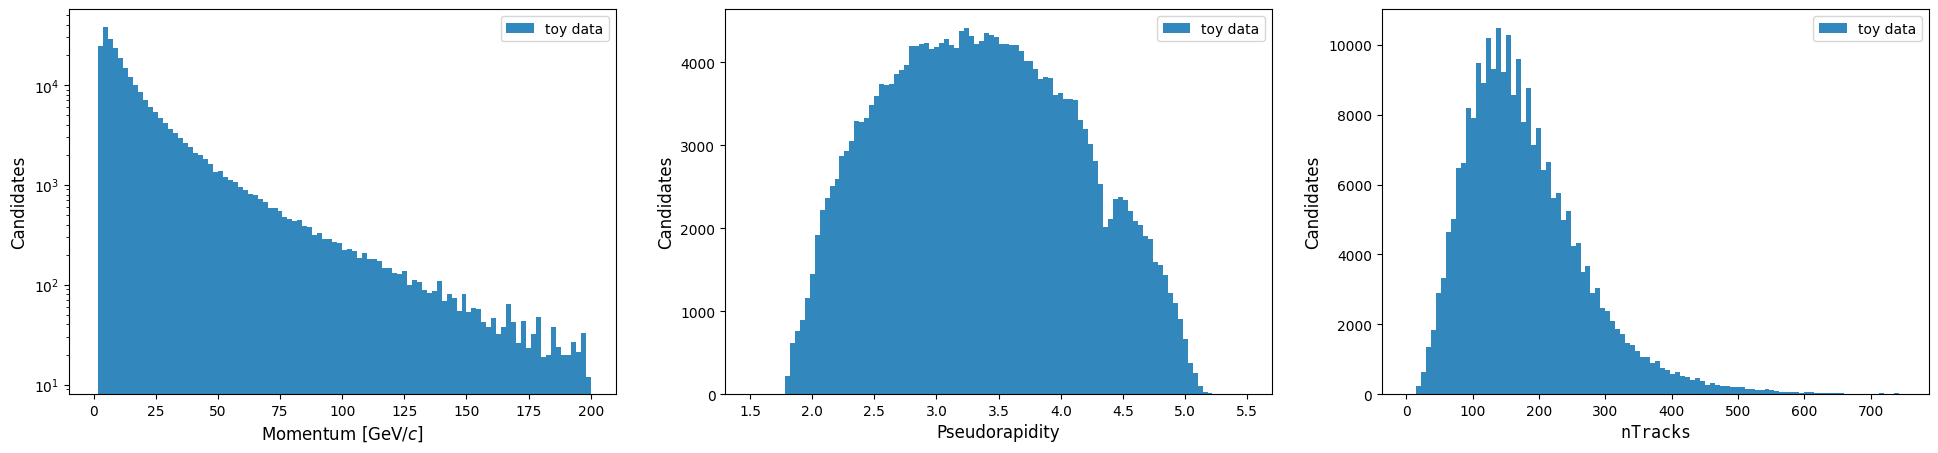

In [6]:
plt.figure(figsize=(24, 5))

plt.subplot(1, 3, 1)
plt.xlabel("Momentum [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["P"]/1e3, bins=np.linspace(0.0, 200.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(1, 3, 2)
plt.xlabel("Pseudorapidity", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["ETA"], bins=np.linspace(1.5, 5.5, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 3, 3)
plt.xlabel("$\mathtt{nTracks}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["nTracks"], bins=np.linspace(0.0, 750.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

The high-level response of the RICH detectors describes how good the reconstructed circles match with a specific particle hypothesis in terms of **differential log-likelihood** (DLL). We aim to build a model able to reproduce the following output features:
* `data.RichDLLe` - RICH DLL between the electron and pion tracks
* `data.RichDLLmu` - RICH DLL between the muon and pion tracks
* `data.RichDLLk` - RICH DLL between the kaon and pion tracks
* `data.RichDLLp` - RICH DLL between the proton and pion tracks

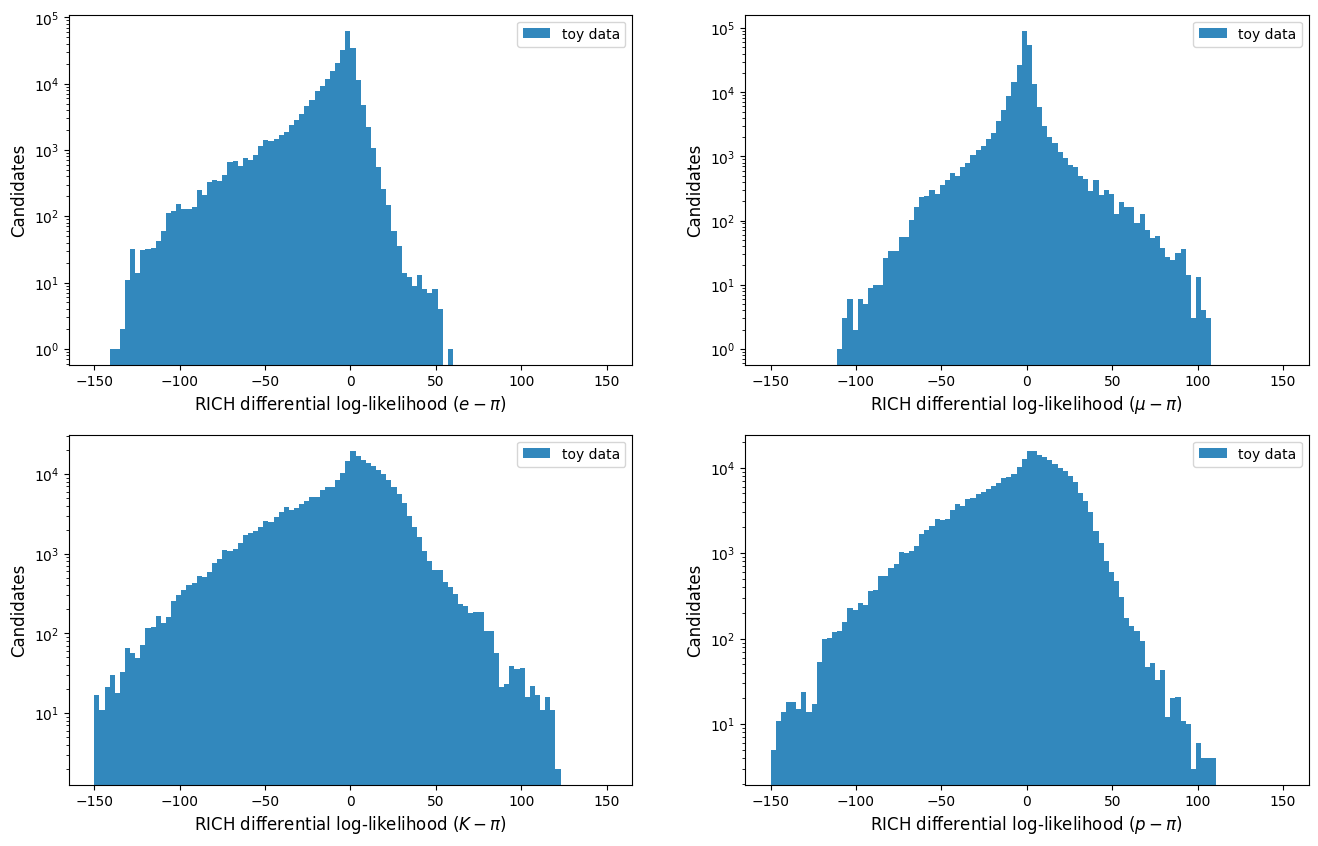

In [7]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.xlabel("RICH differential log-likelihood $(e - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLe"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 2)
plt.xlabel("RICH differential log-likelihood $(\mu - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLmu"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 3)
plt.xlabel("RICH differential log-likelihood $(K - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLk"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 2, 4)
plt.xlabel("RICH differential log-likelihood $(p - \pi)$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["RichDLLp"], bins=np.linspace(-150.0, 150.0, 101), color="#3288bd", label="toy data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

### Data preprocessing

As usual in a machine learning application, the data sample is split into **training** and **test set**.

In [8]:
data = shuffle(data)

x_vars = ["P", "ETA", "nTracks", "trackcharge"]
x = data[x_vars].values

y_vars = ["RichDLLe", "RichDLLmu", "RichDLLk", "RichDLLp"]
y = data[y_vars].values

x_train, x_test = x[:150000], x[150000:]
y_train, y_test = y[:150000], y[150000:]

print(f"x_train shape: {x_train.shape} \t x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}")

x_train shape: (150000, 4) 	 x_test shape: (100000, 4)
y_train shape: (150000, 4) 	 y_test shape: (100000, 4)


To normalize the different ranges and orders of magnitude of input $x$ and output $y$ features highlighted by the previous histograms, we will use the scikit-learn [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) using a Gaussian as output distribution.

Since one of the $x$ features is boolean (`data.trackcharge`), the latter should be kept unchanged. Let's preprocess the rest of the conditional information and verify the results with the [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) `describe()` method:

In [9]:
x_scaler = QuantileTransformer(output_distribution="normal")
x_train_prep = x_scaler.fit_transform(x_train[:, :3])
x_train_prep = np.c_[x_train_prep, x_train[:, 3]]

pd.DataFrame(x_train_prep, columns=x_vars).describe()

,P,ETA,nTracks,trackcharge
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,-0.014230,-0.016377,0.000533,0.021067
std,1.006069,1.007570,1.012490,0.999781
min,-5.199338,-5.199338,-5.199338,-1.000000
25%,-0.686893,-0.685891,-0.656486,-1.000000
50%,-0.020590,-0.024098,0.002509,1.000000
75%,0.654561,0.669050,0.664287,1.000000
max,5.199338,5.199338,5.199338,1.000000


Let's preprocess also the $y$ features checking what obtained:

In [10]:
y_scaler = QuantileTransformer(output_distribution="normal")
y_train_prep = y_scaler.fit_transform(y_train)

pd.DataFrame(y_train_prep, columns=y_vars).describe()

,RichDLLe,RichDLLmu,RichDLLk,RichDLLp
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.010188,-0.011044,0.003597,-0.010576
std,1.000067,0.990031,1.003903,1.008098
min,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.666851,-0.686200,-0.677827,-0.676853
50%,0.003912,-0.012541,0.012427,-0.012032
75%,0.685760,0.665781,0.675098,0.670225
max,5.199338,5.199338,5.199338,5.199338


### Model definition

We are finally ready to define the **BceGAN model** to be used to parameterize the RICH response. GAN algorithms rely on the competition (namely the minimax game) between the generator and discriminator networks. The latters are provided by the [pidgan](https://github.com/mbarbetti/pidgan) package through the [`players`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/players) module that implements the two networks customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

#### The generator

The **generator player** can be implemented with the high-level [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Before to initialize a `Generator` instance, let's have a look at its arguments:

* **`output_dim`** (_int_) - Dimensionality of the generator output space.
* **`latent_dim`** (_int_) - Dimensionality of the latent space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default=None) - Activation function to use in the generator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the generator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the generator layer computations and weights.

In [11]:
from pidgan.players.generators import Generator

generator = Generator(
    output_dim=y.shape[-1],
    latent_dim=64,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="generator"
)

In [12]:
_ = generator(keras.Input(shape=x.shape[1:]))
generator.summary()

Model: "generator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               8832      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)             

#### The discriminator

The **discriminator player** can be implemented with the high-level [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Again, before to initialize a `Discriminator` instance, let's have a look to its arguments:

* **`output_dim`** (_int_) - Dimensionality of the discriminator output space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default="sigmoid") - Activation function to use in the dicriminator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the discriminator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the discriminator layer computations and weights.

In [13]:
from pidgan.players.discriminators import Discriminator

discriminator = Discriminator(
    output_dim=1,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation="sigmoid",
    name="discriminator"
)

In [14]:
_ = discriminator((keras.Input(shape=x.shape[1:]), keras.Input(shape=y.shape[1:])))
discriminator.summary()

Model: "discriminator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               1152      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)         

#### The BceGAN algorithm

The **original BceGAN algorithm** [[2][2]] can be implemented with the high-level [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) class that defines the training procedure of the two players customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class and, in particular, its `fit()` method. Once again, before to initialize a `BceGAN` instance, let's have a look at its arguments:

* **`generator`** (_generator_like_) - The generator network. It must be passed as a pidgan [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) instance.
* **`discriminator`** (_discriminator_like_) - The discriminator network. It must be passed as a pidgan [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) instance.
* **`from_logits`** (_bool_, default=False) - Whether to interpret the discriminator output as a tensor of [logit](https://en.wikipedia.org/wiki/Logit) values. By default, we assume that the discriminator outputs probabilities (i.e., values in [0, 1]).
* **`label_smoothing`** (_float_, default=0.0) - Float in [0, 1]. When 0, no smoothing occurs. When > 0, we compute the loss between the predicted labels and a smoothed version of the true labels, where the smoothing squeezes the labels towards 0.5. Larger values of `label_smoothing` correspond to heavier smoothing.
* **`injected_noise_stddev`** (_float_, default=0.0) - When different from zero, it represents the standard deviation of the gaussian noise added to the discriminator input to stabilize the training procedure following what described in Ref. [[3][3]].
* **`feature_matching_penalty`** (_float_, default=0.0) - Importance of the regularization term added to the generator training to force the hidden state of the discriminator to match between reference and generated examples. Its design follows from what proposed in Ref. [[6][6]].
* **`referee`** (_classifier_like_ or _None_, default=None) - When passed it enables the training of a third independent player: the referee network. It can be used to assess the quality of the generator output during the training. If passed, it must be a pidgan [`Classifier`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/classifiers/Classifier.py) instance.
* **`name`** (_str_ or _None_, default="BceGAN") - The name of the BceGAN model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the BceGAN model computations.

[2]: https://arxiv.org/abs/1511.06434
[3]: https://arxiv.org/abs/1701.04862
[6]: https://arxiv.org/abs/1606.03498

To not further complicate this tutorial, we avoid to use the referee network in this case, even if its initialization is straightforward:

```python
from pidgan.players.classifiers import Classifier

referee = Classifier(
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    name="referee"
)
```

It's time to initialize a [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) instance!

In [15]:
from pidgan.algorithms import BceGAN

gan = BceGAN(
    generator=generator,
    discriminator=discriminator,
    from_logits=False,
    label_smoothing=0.1,
    injected_noise_stddev=0.05,
    feature_matching_penalty=0.0,
    referee=None,
    name="BceGAN",
)

#### Model compilation

To finalize the [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) model preparation before to run the training procedure, we need to execute the `compile()` method. Differently from the TensorFlow `compile()` method, the [pidgan](https://github.com/mbarbetti/pidgan) one doesn't require to pass the loss function since it is encoded in the customized `gan.fit()` method. The arguments of the `gan.compile()` method follows:

* **`metrics`** (_list_ or _None_, default=None) - If not None, list of metrics to be evaluated by the BceGAN model during training and testing. Each of this can be a string (name of a built-in pidgan function) or a [`pidgan.metrics`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/metrics) instance.
* **`generator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the generator network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`discriminator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the discriminator network. (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`generator_upds_per_batch`** (_int_, default=1) - Number of the generator weights updates per batch of data.
* **`discriminator_upds_per_batch`** (_int_, default=1) - Number of the discriminator weights updates per batch of data.
* **`referee_optimizer`** (_optimizer_like_ or _None_, default=None) - If not None, string (name of optimizer) or optimizer instance for the referee network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`referee_upds_per_batch`** (_int_ or _None_, default=None) - If not None, number of the referee weights updates per batch of data.

In [16]:
gan.compile(
    metrics=["accuracy", "bce"],
    generator_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    discriminator_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    referee_optimizer=None,
    referee_upds_per_batch=None,
)

### Training procedure

The [pidgan](https://github.com/mbarbetti/pidgan) package provides several learning rate scheduling strategies through the [`callbacks.schedulers`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/callbacks/schedulers) module. The pidgan schedulers are designed as [custom TensorFlow callbacks](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks) that also allow to trace the learning rate value of each passed optimizer during the training. In this tutorial, we will use an exponential decay schedule both for the generator and discriminator networks:

<center>$\eta(t) = \eta_0 \cdot e^{- \alpha \cdot t / \tau}$</center>

where $\eta(t)$ indicates the learning rate value at a specific training step $t$, $\eta_0$ the initial learning rate, $\alpha$ the decay rate and $\tau$ the decay step.

In [17]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

schedules = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=50000,
    min_learning_rate=1e-6,
    verbose=True,
    key="g_lr",
)
schedules.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=75000,
    min_learning_rate=1e-6,
    verbose=True,
    key="d_lr",
)
schedules.append(d_lr_sched)

Calling `gan.fit()` allows to perform the **minimax two-player game**, training the generator to reproduce the reference space $y$ on the basis of the conditions $x$ thanks to the discriminator feedbacks. The arguments taken by the pidgan `fit()` method are the same ones traditionally passed to a TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) instance. The schedulers are passed through the `callbacks` argument and, since their verbosity has been enabled (`verbose` and `key` passed), the learning rates of both the generator and discriminator are printed during the training procedure.

**Note:** Training the [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) model on Colab using the hyperparameters chosen for this tutorial (i.e., batch-size, epochs, updates per batch) takes about 20 minutes with no-GPU equipped or 10 minutes enabling the T4-powered runtime.

In [18]:
start = datetime.now()

train = gan.fit(
    x=x_train_prep,
    y=y_train_prep,
    batch_size=256,
    epochs=100,
    validation_split=0.3,
    callbacks=schedules,
    verbose=1,
)

stop = datetime.now()

print(f"Training procedure completed in {stop - start}")

Epoch 1/100
  4/411 [..............................] - ETA: 9s - g_loss: 0.6663 - d_loss: 0.6852 - accuracy: 0.9775 - bce: 0.6578 - g_lr: 9.9993e-04 - d_lr: 4.9998e-04 

411/411 [==============================] - 29s 20ms/step - g_loss: 0.7623 - d_loss: 0.6820 - accuracy: 0.3985 - bce: 0.7272 - g_lr: 9.9060e-04 - d_lr: 4.9686e-04 - val_g_loss: 0.7000 - val_d_loss: 0.6880 - val_accuracy: 0.5176 - val_bce: 0.7010
Epoch 2/100
411/411 [==============================] - 6s 15ms/step - g_loss: 0.7033 - d_loss: 0.6931 - accuracy: 0.5030 - bce: 0.6950 - g_lr: 9.7202e-04 - d_lr: 4.9063e-04 - val_g_loss: 0.6819 - val_d_loss: 0.6961 - val_accuracy: 0.6658 - val_bce: 0.6806
Epoch 3/100
411/411 [==============================] - 6s 15ms/step - g_loss: 0.6966 - d_loss: 0.6932 - accuracy: 0.5167 - bce: 0.6934 - g_lr: 9.5380e-04 - d_lr: 4.8448e-04 - val_g_loss: 0.6838 - val_d_loss: 0.6949 - val_accuracy: 0.6254 - val_bce: 0.6824
Epoch 4/100
411/411 [==============================] - 7s 16ms/step - g_loss: 0.6966 - d_loss: 0.6929 - accuracy: 0.4945 - bce: 0.6938 - g_lr: 9.3592e-04 - d_lr: 4.7840e-04 - val_g_loss: 0.6884 - val_d_loss: 0.6927 - val_accuracy: 0.5924 - val

The following code cells report the **learning** and **metric curves** for the training just finished.

#### Learning curves

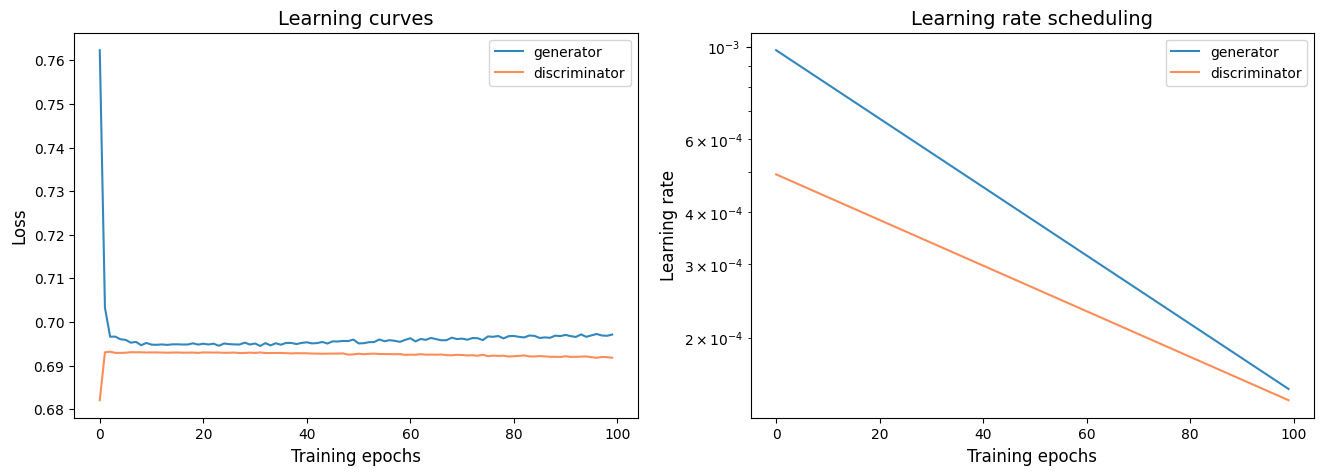

In [19]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

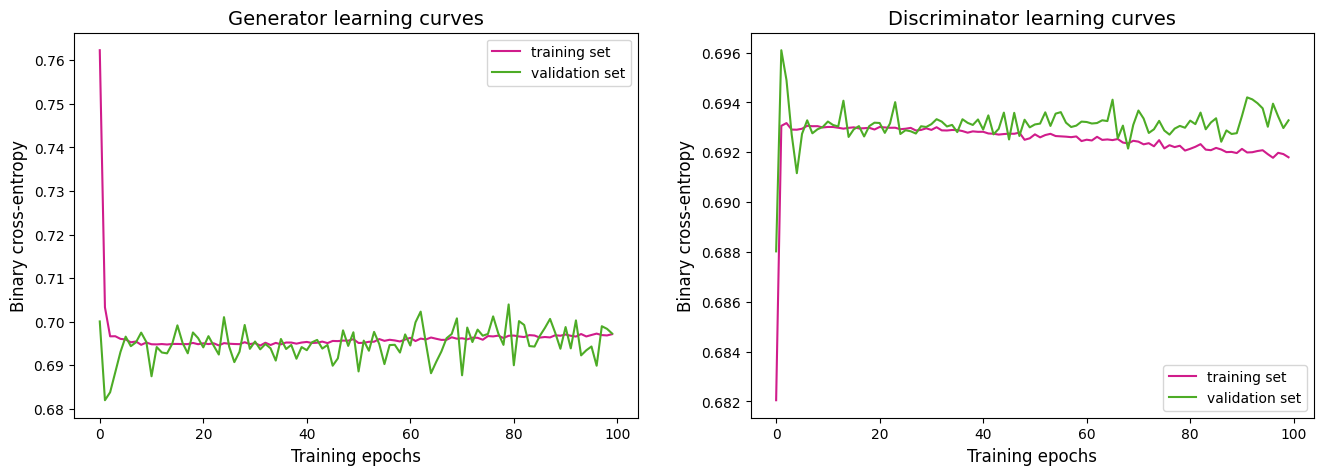

In [20]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

#### Metric curves

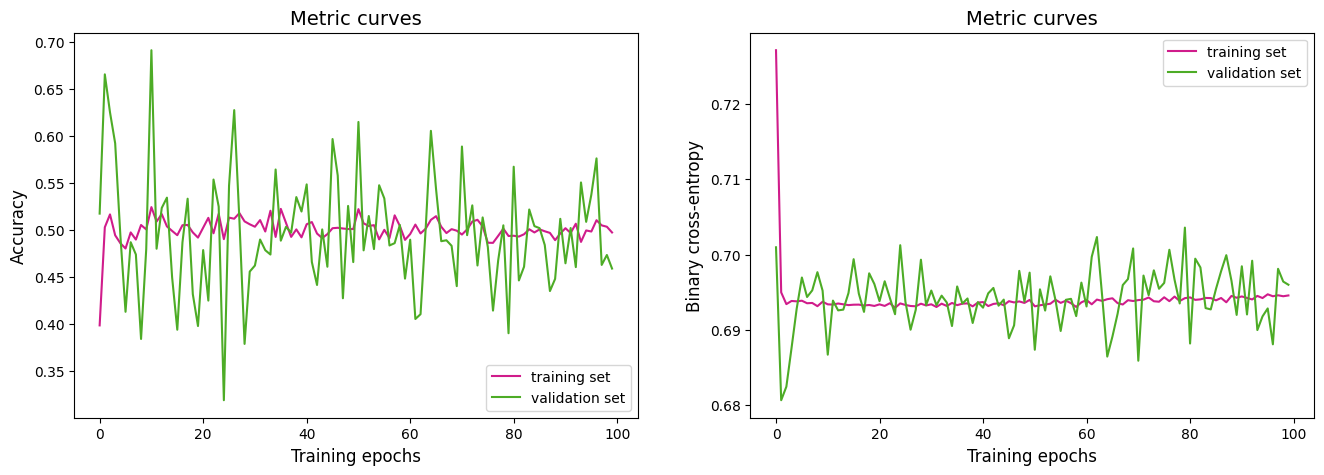

In [21]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.plot(train.history["accuracy"], color="#d01c8b", label="training set")
plt.plot(train.history["val_accuracy"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Binary cross-entropy", fontsize=12)
plt.plot(train.history["bce"], color="#d01c8b", label="training set")
plt.plot(train.history["val_bce"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.show()

### Validation plots

Once trained the GAN system, the **generator model** can be used to parameterize the high-level response of the LHCb RICH detectors, namely the RICH differential log-likelihoods for different particle hypotheses. Let's have a look at the achieved performance on the **test set**!

In [22]:
x_test_prep = x_scaler.transform(x_test[:, :3])  # input pre-processing
x_test_prep = np.c_[x_test_prep, x_test[:, -1]]

out_test = gan.generate(x_test_prep, seed=None)
out_test_post = y_scaler.inverse_transform(out_test)  # output post-processing

#### RICH differential log-likelihood $(e - \pi)$

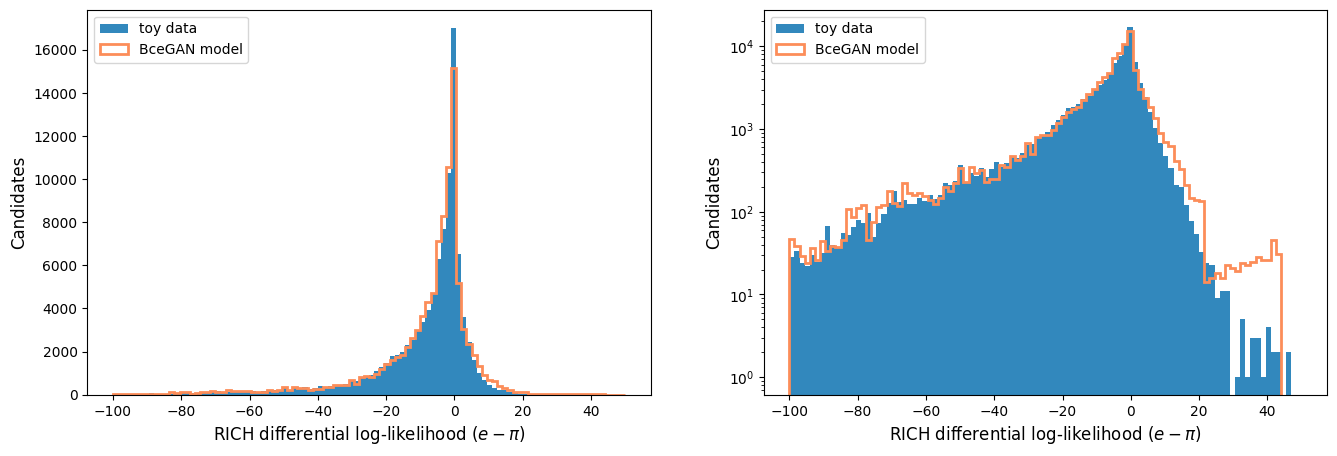

In [23]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-100.0, 50.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(e - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 0], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 0], bins=bins, histtype="step", lw=2, color="#fc8d59", label="BceGAN model")
    plt.legend(loc="upper left", fontsize=10)
    plt.yscale(scale)

plt.show()

#### RICH differential log-likelihood $(\mu - \pi)$

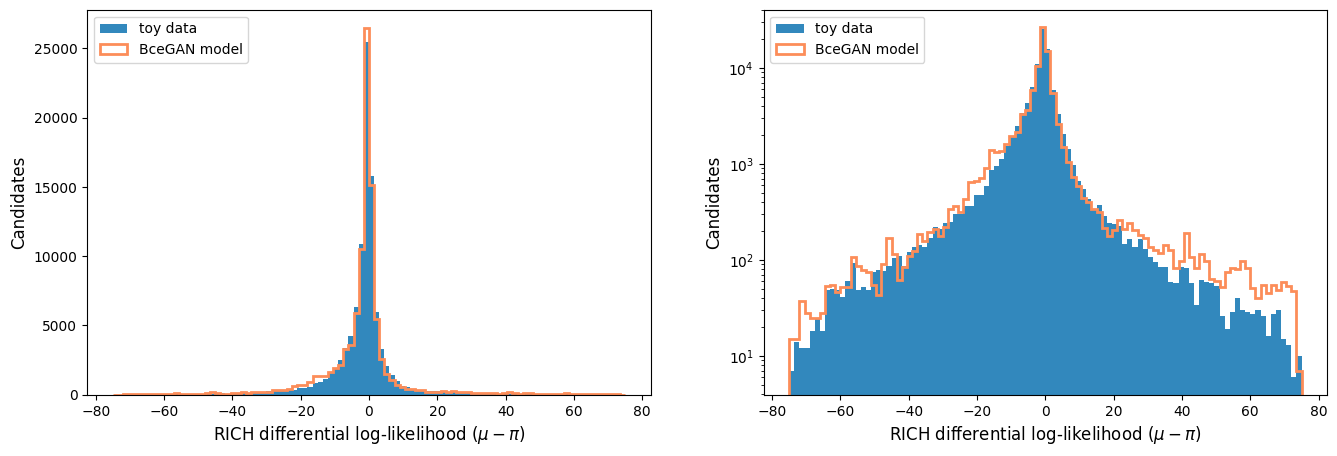

In [24]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-75.0, 75.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(\mu - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 1], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 1], bins=bins, histtype="step", lw=2, color="#fc8d59", label="BceGAN model")
    plt.legend(loc="upper left", fontsize=10)
    plt.yscale(scale)

plt.show()

#### RICH differential log-likelihood $(K - \pi)$

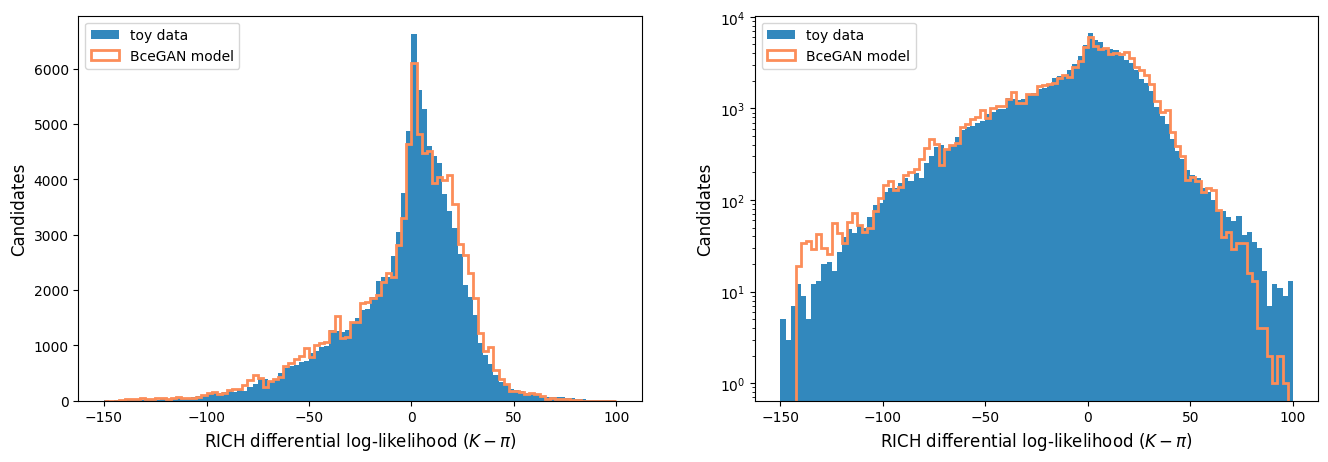

In [25]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-150.0, 100.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(K - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 2], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 2], bins=bins, histtype="step", lw=2, color="#fc8d59", label="BceGAN model")
    plt.legend(loc="upper left", fontsize=10)
    plt.yscale(scale)

plt.show()

#### RICH differential log-likelihood $(p - \pi)$

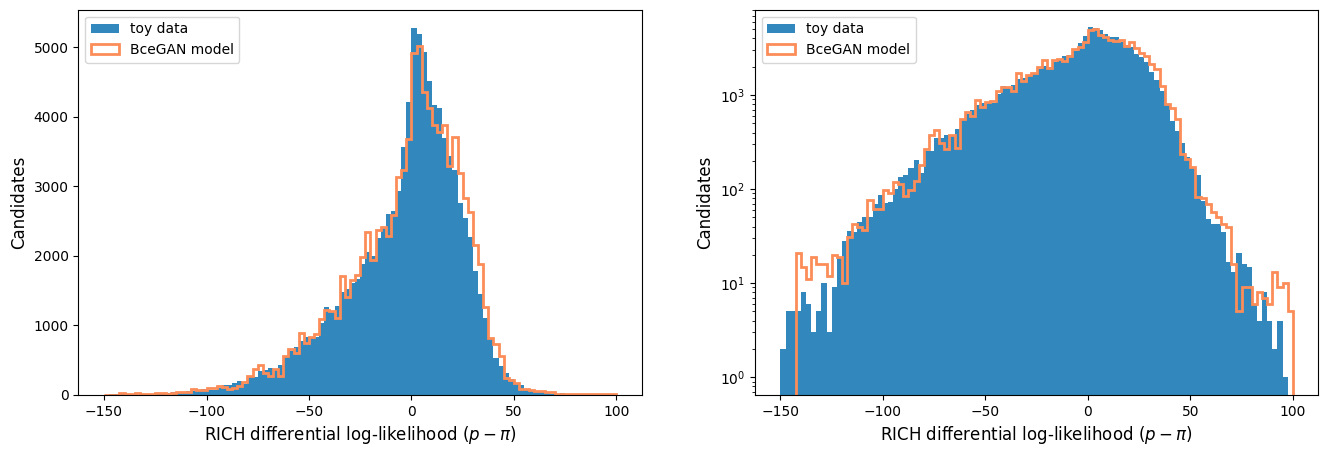

In [26]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-150.0, 100.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("RICH differential log-likelihood $(p - \pi)$", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 3], bins=bins, color="#3288bd", label="toy data")
    plt.hist(out_test_post[:, 3], bins=bins, histtype="step", lw=2, color="#fc8d59", label="BceGAN model")
    plt.legend(loc="upper left", fontsize=10)
    plt.yscale(scale)

plt.show()

### Model export

The [pidgan](https://github.com/mbarbetti/pidgan) package provides the **generator model** with the `export_model()` to export it as a plain [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model to ease the **deployment** of the RICH parameterization through tools like [scikinC](https://github.com/landerlini/scikinC) or [keras2c](https://github.com/f0uriest/keras2c) [[7][7], [8][8]].

[7]: https://pos.sissa.it/409/034
[8]: https://doi.org/10.1016/j.engappai.2021.104182

In [27]:
keras.models.save_model(
    gan.generator.export_model,  # TF Sequential model
    filepath="saved_generator",
    save_format="tf",
)

Exporting the generator as a [TensorFlow SavedModel format](https://www.tensorflow.org/guide/saved_model) file allows to use **scikinC** to transpile the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model to a C file as follows:

In [28]:
%%capture
!scikinC saved_generator > generator.C

In [29]:
!ls -lrth generator.C

-rw-r--r-- 1 root root 1.8M Nov  7 15:52 generator.C


## References

1. I.J. Goodfellow _et al._, "Generative Adversarial Networks", [arXiv:1406.2661][1]
2. A. Radford, L. Metz, S. Chintala, "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", [arXiv:1511.06434][2]
3. M. Arjovsky, L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862][3]
4. M. Mirza, S. Osindero, "Conditional Generative Adversarial Nets", [arXiv:1411.1784][4]
5. A. Maevskiy _et al._, "Fast Data-Driven Simulation of Cherenkov Detectors Using Generative Adversarial Networks", [arXiv:1905.11825][5]
6. T. Salimans _et al._, "Improved Techniques for Training GANs", [arXiv:1606.03498][6]
7. L. Anderlini, M. Barbetti, "scikinC: a tool for deploying machine learning as binaries", [PoS **CompTools2021** (2022) 034][7]
8. R. Conlin _et al._, "Keras2c: A library for converting Keras neural networks to real-time compatible C", [Eng Appl Artif Intell **100** (2021) 104182][8]

[1]: https://arxiv.org/abs/1406.2661
[2]: https://arxiv.org/abs/1511.06434
[3]: https://arxiv.org/abs/1701.04862
[4]: https://arxiv.org/abs/1411.1784
[5]: https://arxiv.org/abs/1905.11825
[6]: https://arxiv.org/abs/1606.03498
[7]: https://pos.sissa.it/409/034
[8]: https://doi.org/10.1016/j.engappai.2021.104182

## Credits
This tutorial is based on the notebooks provided by the [mbarbetti/tf-gen-models](https://github.com/mbarbetti/tf-gen-models) repository.